In [1]:
# Leaky integrator model of Echo State Network
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

In [669]:
PPL_SIZE = 50
N_NODES = 50
INTERNAL_NODE = 49
N_EDGE = 250
N_TEST = 1
SPECT_RADIUS = 0.93
MUTATION_GROWTH = 10
REWIRING_GROWTH = 30
MATING_GROWTH = 20
W_IN = (np.random.rand(N_NODES, 1) * 2 - 1)*0.1
W_IN[-INTERNAL_NODE:] = [0]

trainlen = 1200
future = 1000
buffer = 100

In [670]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200, W=None, W_in=None,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 internal_node=5,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.internal_node = internal_node
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale
        self.W = W
        self.W_in = W_in

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

    def _update(self, state, input_pattern):
        # leaky integrator model:
        # it can adjust timescales for each neurons.
        preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        state = (1 - self.time_scale) * state + self.time_scale * np.tanh(1.5*preactivation)
        # state = (1 - self.time_scale) * state + self.time_scale * preactivation
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = inputs
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        
        self.W_out = np.dot(np.linalg.pinv(states[transient:, :-self.internal_node]),teachers_scaled[transient:, :]).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        pred_train = np.dot(states[:, :-self.internal_node], self.W_out.T)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,states[n + 1, :-self.internal_node])

        return self.out_activation(outputs[1:])


In [671]:
def make_data_for_narma(length):
    tau = 0.01
    buffer = 100
    x = np.random.rand(length+100)*0.5
    y = np.zeros(length)
    for i in range(length):
        if i < 29:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:], y[:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
        else:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
    return x, y

In [672]:
# import numpy as np
# N_NODES=155

In [673]:
def make_init_ppl(spectral_radius):
    population = []
    for i in range(PPL_SIZE):
        W = np.ones(N_NODES**2)*(1/N_NODES)*20
        tmp_mask = [False if np.random.rand()>0.5 else True for i in range(N_NODES**2)]
        W[tmp_mask] = -1*W[tmp_mask]
        tmp = np.random.choice(N_NODES**2, N_EDGE, replace=False)
        mask = [False if i in tmp else True for i in range(N_NODES**2)]
        mask = np.array(mask)
        W[mask] = 0
        W = W.reshape(N_NODES, N_NODES)
        population.append([W, 0.0])
    return population

In [674]:

W = np.ones(N_NODES**2)*(1/N_NODES)*20
tmp_mask = [False if np.random.rand()>0.5 else True for i in range(N_NODES**2)]
W[tmp_mask] = -1/N_NODES
tmp = np.random.choice(N_NODES**2, N_EDGE, replace=False)
mask = [False if i in tmp else True for i in range(N_NODES**2)]
mask = np.array(mask)
W[mask] = 0
W= W.reshape(N_NODES, N_NODES)
radius = np.max(np.abs(np.linalg.eigvals(W)))
print(radius)


0.8595370894114974


In [791]:
spectral_radius = 0.98
W = np.random.normal(0, 1/N_NODES, N_NODES**2)
tmp = np.random.choice(N_NODES**2, N_EDGE, replace=False)
mask = [False if i in tmp else True for i in range(N_NODES**2)]
mask = np.array(mask)
W[mask] = 0
W = W.reshape(N_NODES, N_NODES)
radius = np.max(np.abs(np.linalg.eigvals(W)))
W = W * (spectral_radius / radius)
# print(radius)

In [792]:
time_scale = np.ones(N_NODES)
time_scale[-5:] = 0.05
esn = LI_ESN_internal(n_inputs=1,
                      W=W,
                      W_in=W_IN,
                      n_outputs=1,
                      n_reservoir=N_NODES,
                      noise=0,
                      internal_node=INTERNAL_NODE,
                      time_scale=time_scale)

data, target = make_data_for_narma(trainlen+future)
# print(data.shape)
# pred_training = esn.fit(data[buffer:buffer+trainlen], target[:trainlen])
# prediction = esn.predict(data[trainlen+buffer:])
# print(np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[trainlen:], -1))**2)/np.var(target[trainlen:])))


t = np.arange(0,100,0.1)
sin_data = np.sin(t) +  0.5*np.sin(10*t) 
# sin_data = np.sin(t) +  0.5*np.sin(5*t) 
inputs = sin_data*5
# inputs = data
if inputs.ndim < 2:
    inputs = np.reshape(inputs, (len(inputs), -1))
states = np.zeros((inputs.shape[0], esn.n_reservoir))
for n in range(1, inputs.shape[0]):
    # print(states[n-1])
    states[n, :] = esn._update(states[n - 1], inputs[n, :])

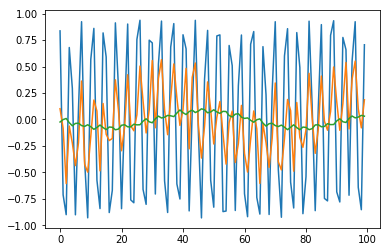

In [799]:
# plt.plot(sin_data[200:300])
plt.plot(states.T[-12][200:300])
plt.plot(states.T[-7][200:300])
plt.plot(states.T[-1][200:300])
plt.savefig('oscillation2.png')

In [587]:
time_scale = np.ones(N_NODES)
# time_scale[-3:] = 0.1
def generation(time_scale, population, n_ppl=PPL_SIZE, n_test=N_TEST):
    data_pool = []
    for i in range(len(population)):
        esn = LI_ESN_internal(n_inputs=1,
                              W=population[i][0],
                              W_in=W_IN,
                              n_outputs=1,
                              n_reservoir=N_NODES,
                              noise=0,
                              internal_node=INTERNAL_NODE,
                              time_scale=time_scale)
        fitness_list = []
        for k in range(n_test):
            data, target = make_data_for_narma(trainlen+future)
            pred_training = esn.fit(data[buffer:buffer+trainlen], target[:trainlen])
            prediction = esn.predict(data[trainlen+buffer:])
            fitness = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[trainlen:], -1))**2)/np.var(target[trainlen:]))
            fitness_list.append(fitness)
        # print(np.mean(fitness_list))
        population[i][1] = np.mean(fitness_list)
    return population

In [10]:
def mutation(population, n_growth=MUTATION_GROWTH, n_ppl=PPL_SIZE):
    for i in np.random.choice(n_ppl, n_growth, replace=False):
        tmp_W = population[i][0].reshape(N_NODES**2)
        while True:
            mutation_index = np.random.choice(N_NODES**2)
            if abs(tmp_W[mutation_index]) > 0:
                break
        tmp_W[mutation_index] = -1*tmp_W[mutation_index]
        population.append([tmp_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [11]:
def rewiring(population, n_growth=REWIRING_GROWTH, n_ppl=PPL_SIZE):
    for i in np.random.choice(n_ppl, n_growth, replace=False):
        tmp_W = population[i][0].reshape(N_NODES**2)
        while True:
            rewiring_index = np.random.choice(N_NODES**2)
            if abs(tmp_W[rewiring_index]) > 0:
                break
        if np.random.rand() > 0.5:
            j = rewiring_index % N_NODES
            new_rewiring_index = np.random.choice(N_NODES)*N_NODES+j
        else:
            i = rewiring_index // N_NODES
            new_rewiring_index = i*N_NODES + np.random.choice(N_NODES)
        tmp_saved = tmp_W[new_rewiring_index]
        tmp_W[new_rewiring_index] = tmp_W[rewiring_index]
        tmp_W[rewiring_index] = tmp_saved
        population.append([tmp_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [12]:
def mating(population, n_growth=MATING_GROWTH, n_ppl=PPL_SIZE):
    for n in range(n_growth):
        i, j = np.random.choice(n_ppl, 2, replace=False)
        overlap = []
        oneside_tuple = []
        parent1 = population[i][0].reshape(N_NODES**2)
        parent2 = population[j][0].reshape(N_NODES**2)
        for k in range(N_NODES**2):
            if parent1[k]*parent2[k] != 0:
                overlap.append(k)
            elif parent1[k] != 0 or parent2[k] != 0:
                oneside_tuple.append((1 if parent1[k] != 0 else 2, k))
        new_W = np.zeros(N_NODES**2)
        if len(overlap) > 0:
            for edge_index in overlap:
                new_W[edge_index] = parent1[edge_index] if np.random.rand() > 0.5 else parent2[edge_index]
        if len(oneside_tuple) > 0:
            selected_index = np.random.choice(len(oneside_tuple), N_EDGE-len(overlap), replace=False)
            for edge_index in selected_index:
                new_W[oneside_tuple[edge_index][1]] = parent1[oneside_tuple[edge_index][1]] if oneside_tuple[edge_index][0]==1 else parent2[oneside_tuple[edge_index][1]]
        population.append([new_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [13]:
def natural_selection(population, n_ppl=PPL_SIZE):
    fitness_list = [population[i][1] for i in range(len(population))]
    argsort = np.argsort(fitness_list)
    population = np.array(population)
    sorted_population = population[argsort, :]
    population_strong = sorted_population[:n_ppl-10]
    print('best_fitness:', sorted_population[0][1],sorted_population[1][1], sorted_population[2][1], 'average_fitness:', np.mean([population[i][1] for i in range(n_ppl)]))
    population_strong = population_strong.tolist()
    population_random_idx = np.random.choice(len(population), 10)
    population_random = [population[idx] for idx in population_random_idx]
    population = population_strong+population_random
    return population

In [14]:
init_population = make_init_ppl(SPECT_RADIUS)

In [16]:
import time
new_population = make_init_ppl(SPECT_RADIUS)
start = time.time()
for generation_idx in range(500):
    new_population = mating(new_population)
    new_population = rewiring(new_population)
    new_population = mutation(new_population)
    new_population = generation(time_scale, new_population)
    print(generation_idx+1, time.time()-start)
    new_population = natural_selection(new_population)

1 26.88424324989319
best_fitness: 0.6354332366375285 0.6450118534126995 0.6507180363744248 average_fitness: 0.7179262765778717
2 53.839845418930054
best_fitness: 0.6298531981949093 0.6373793721437924 0.6462281384888179 average_fitness: 0.693729181386618
3 80.69064927101135
best_fitness: 0.6281266843959519 0.644796396179508 0.6448540870812679 average_fitness: 0.6893738753017715
4 107.64224624633789
best_fitness: 0.6389523954660564 0.6476790189121484 0.6482126935603684 average_fitness: 0.6905508443592432
5 134.5257408618927
best_fitness: 0.635566807609978 0.6441392537587101 0.6471606653601578 average_fitness: 0.6986099135358895
6 161.64461159706116
best_fitness: 0.6324122146582026 0.6351723937140309 0.6636151774116806 average_fitness: 0.7017865883383232
7 188.53524374961853
best_fitness: 0.6485618670556905 0.6517156529401266 0.6553178791430055 average_fitness: 0.7095540354874639
8 215.48061108589172
best_fitness: 0.6529725108810243 0.6534817832846934 0.6535865894470719 average_fitness: 0

66 1788.619703054428
best_fitness: 0.5158896153341593 0.5301819955364022 0.5486637305220393 average_fitness: 0.6004524796377452
67 1815.6529767513275
best_fitness: 0.5362723787466351 0.5518796955766488 0.5531781604848657 average_fitness: 0.6182489259645769
68 1842.6972115039825
best_fitness: 0.5428508508036882 0.5439236228227825 0.5467193777781153 average_fitness: 0.6092127560409155
69 1869.6157066822052
best_fitness: 0.521418735248907 0.5266771408880795 0.5277595004214672 average_fitness: 0.598927260115239
70 1896.5037777423859
best_fitness: 0.5337266552307005 0.5347357128782232 0.5412903377069738 average_fitness: 0.605244340576848


KeyboardInterrupt: 

In [127]:
np.save('population_for_weight_fixed_network2.npy', new_population)

In [84]:
for generation_idx in range(11, 300):
    new_population = generation(time_scale, new_population)
    print(generation_idx+1)
    new_population = natural_selection(new_population)
    new_population = mating(new_population)
    new_population = rewiring(new_population)
    new_population = mutation(new_population)
    

12
best_fitness: 0.7429109498724193 0.7433224000816121 0.7442738899278613 average_fitness: 0.7517627745218103
13
best_fitness: 0.7419919935463367 0.7432545486442432 0.743527261007795 average_fitness: 0.75213170702539
14
best_fitness: 0.7397129312726817 0.7408272766173744 0.7424166988704461 average_fitness: 0.750957955343961
15
best_fitness: 0.7422807471906558 0.7425551511952603 0.7428491877119179 average_fitness: 0.7511981143151749
16
best_fitness: 0.7386716538624025 0.7388052629940203 0.7420374510601755 average_fitness: 0.7498421636648218
17
best_fitness: 0.7394356754573925 0.7419640810705816 0.7421536649124791 average_fitness: 0.7499349236891498
18
best_fitness: 0.7408331398751338 0.7419826723130616 0.7421612702734205 average_fitness: 0.7498159326474036
19
best_fitness: 0.7410130676673153 0.7410820724637976 0.742059061519197 average_fitness: 0.7508178470622865
20
best_fitness: 0.7374189070795231 0.7390430255940268 0.7417186470604974 average_fitness: 0.7507169601138293
21
best_fitness

87
best_fitness: 0.7309267170899896 0.7317694159562155 0.7331940400907749 average_fitness: 0.7429435638745845
88
best_fitness: 0.7289262209087368 0.7292062522840385 0.7307558802055052 average_fitness: 0.7409914007606795
89
best_fitness: 0.730507556836199 0.7318413600557231 0.7324614331925267 average_fitness: 0.7438255588119012
90
best_fitness: 0.7326999528439206 0.7328039035686257 0.7328479796016609 average_fitness: 0.7439384192979637
91
best_fitness: 0.7284647927680704 0.7329047463249868 0.7342838618033265 average_fitness: 0.7434778819720462
92
best_fitness: 0.7311564757489479 0.7322961067404508 0.7323004775191257 average_fitness: 0.7427341522167413
93
best_fitness: 0.7290650302181263 0.7301656522617025 0.7318606006972035 average_fitness: 0.7434355094899783
94
best_fitness: 0.7310654149740123 0.7312602305573634 0.7314609655513516 average_fitness: 0.7429772672389952
95
best_fitness: 0.7282565527969267 0.7294874649807197 0.7313205368354474 average_fitness: 0.7423646784627099
96
best_fit

162
best_fitness: 0.6983045176779897 0.6991471769860288 0.69938195059394 average_fitness: 0.7102221206210723
163
best_fitness: 0.6956830926271436 0.6975470973358494 0.6994215620048296 average_fitness: 0.7162583475622896
164
best_fitness: 0.6980664287552145 0.6999855332612109 0.7004983831097789 average_fitness: 0.7130794040492805
165
best_fitness: 0.6975894816797705 0.6978579423477415 0.6981536910175283 average_fitness: 0.7087963598115427
166
best_fitness: 0.6978315158076258 0.6989890856007978 0.7012057333519784 average_fitness: 0.7123371988931646
167
best_fitness: 0.6994173333239684 0.6997125820473775 0.6999114577152709 average_fitness: 0.7138291027186507
168
best_fitness: 0.6988726076725627 0.6998765685311564 0.7005195089324525 average_fitness: 0.7116478032389908
169
best_fitness: 0.6987539594830288 0.698806819567013 0.6999864529295475 average_fitness: 0.7142040301778357
170
best_fitness: 0.6944652041368361 0.6988418471700026 0.699023775580771 average_fitness: 0.7148479860271445
171
b

237
best_fitness: 0.6735711154564373 0.675810116287787 0.6769580164472433 average_fitness: 0.6943263583684274
238
best_fitness: 0.6714204359165761 0.6718847872743445 0.6748603453802539 average_fitness: 0.6883561937428487
239
best_fitness: 0.6749047611520114 0.6774207661354955 0.6775169984835644 average_fitness: 0.6975447903292956
240
best_fitness: 0.676498697099148 0.679619862735769 0.6796512838869337 average_fitness: 0.7011730527832407
241
best_fitness: 0.6770959113684027 0.6778554456932413 0.6784220095348752 average_fitness: 0.6937830764779165
242
best_fitness: 0.6740936135921418 0.67471891259403 0.6758001911215198 average_fitness: 0.6983181344393395
243
best_fitness: 0.6762502504219434 0.676335637757379 0.6766469740652326 average_fitness: 0.6931157995040816
244
best_fitness: 0.6741704283861639 0.674462690949883 0.6756523012088079 average_fitness: 0.6946300957089668
245
best_fitness: 0.6743807569664211 0.6764140183702743 0.6779348043473745 average_fitness: 0.6940864179517585
246
best

In [85]:
# np.save('population_for_weight_fixed_network.npy', new_population)

In [98]:
new_population[0][0].shape

(50, 50)

In [99]:
for i in range(new_population[0][0].shape[0]):
    print(new_population[0][0][i])

[-0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.02  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[ 0.    0.    0.    0.    0.   -0.02  0.    0.    0.    0.4   0.    0.
  0.    0.    0.4   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.4  -0.02  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.4   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 0.    0.    0.   -0.02  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.4   0.    0.4   0.4   0.    0.    0.    0.    0.    0.4   0.
  0.    0.    0.    0.    0.    0.   

In [ ]:
# speciationして構造を保護したほうがいいかもしれない！！！
# タスクの選定は大事。J_ijの違いがパフォーマンスに強く影響を与える設定が望ましい。
# noiseを加えるのは考えてみてもいいかも。
# sparsityを変えてみるとか。
# W_inも最適化させた方がいい気がする。